In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch import Tensor, optim, cuda
from torch.autograd import Variable
from torch.nn import functional as F
from torch.utils.data import Dataset
import torch.nn as nn
import csv
import os
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch import Tensor, optim, cuda
from torch.autograd import Variable
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import csv
import os

from data.data import DeClareDataset
from model.deClare import DeClareModel

In [2]:
torch.__version__

'1.0.0'

# Load Datasets

In [3]:
SNOPES_LOC = "./Datasets/Snopes/snopes.tsv"
#consists of rumors analyzed on the Snopes website along with their credibility labels (true or false), 
#sets of reporting articles, and their respective web sources

POLITIFACT_LOC = "./Datasets/PolitiFact/politifact.tsv"

glove_data_file = "./Glove/glove.6B.100d.txt"

In [4]:
snopes = DeClareDataset(SNOPES_LOC, glove_data_file)

Successfully read news data from ./Datasets/Snopes/snopes.tsv
Number of articles = 29242
Number of claims = 4341
Using pre-built vocabulary


## Preliminary Analysis

In [5]:
batch_size = 4
nb_lstm_units = 64

In [6]:
dataloader = DataLoader(snopes, batch_size, shuffle=True)

In [7]:
declare = DeClareModel(snopes.initial_embeddings, snopes.claim_source_vocab_size, 
                       snopes.article_source_vocab_size, nb_lstm_units, batch_size)

In [8]:
optimizer = optim.Adam(declare.parameters(), lr=0.002)
BCEloss = nn.BCELoss()

In [10]:
losses = []
for data_sample in dataloader:
    declare.zero_grad()
    idx = np.argsort(-data_sample[3])
    
    out = declare(data_sample[0][idx], data_sample[1][idx], data_sample[2][idx], data_sample[3][idx], data_sample[4][idx], data_sample[5][idx])
    loss = BCEloss(out, data_sample[6][idx].float())
    
    losses.append(loss.data)
    
    loss.backward()
    optimizer.step()

KeyboardInterrupt: 

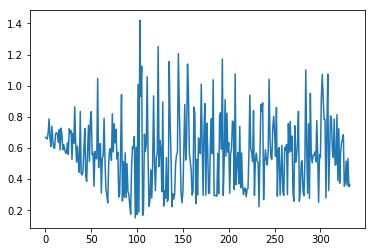

In [11]:
plt.plot(losses)

In [10]:
float(snopes.news_df['Credibility'][0] == 'true')

1.0

In [11]:
snopes.news_df['Claim'].iloc[0]

'best buy chain eschewing use word christmas 2006 holiday print advertising'

In [12]:
snopes.news_df['Article'].str.split().str.len().min()

21

In [29]:
idxes = torch.arange(0,10,out=torch.LongTensor(10)).unsqueeze(0) # some day, you'll be able to directly do this on cuda

In [33]:
Variable((idxes<data_sample[3].unsqueeze(1)).float())

tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])

In [38]:
data_sample[3].unsqueeze(1).shape

torch.Size([4, 1])

In [37]:
idxes.shape

torch.Size([1, 10])

In [41]:
torch.ones((5,2))

tensor([[1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.]])